In [1]:
from yahoo_finance import Currency
from matplotlib.finance import quotes_historical_yahoo_ohlc
from datetime import datetime
import pandas as pd
import numpy as np

/Users/liang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Historical Data

![10 yr data](../Desktop/rateHistorical.png)

![corrComparison](../Desktop/corrCompare.png)

In [3]:
start_date = (2015, 8, 12)
end_date = datetime.utcnow().date()
rmb_usd = quotes_historical_yahoo_ohlc('CNY=X', start_date, end_date)
df = pd.DataFrame(rmb_usd)

close_rate = df[[4]]

# Test Stationarity

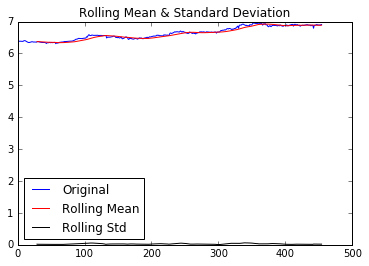

Results of Dickey-Fuller Test:
Test Statistic                  -0.497124
p-value                          0.892577
#Lags Used                       2.000000
Number of Observations Used    452.000000
Critical Value (5%)             -2.867956
Critical Value (1%)             -3.444900
Critical Value (10%)            -2.570187
dtype: float64


In [4]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pylab as plt
%matplotlib inline

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

test_stationarity(close_rate[4])

# Towards Stationarity

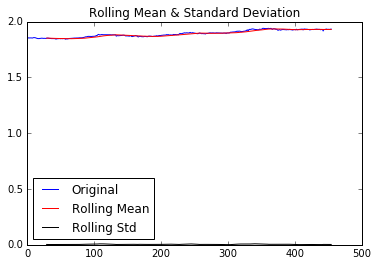

Results of Dickey-Fuller Test:
Test Statistic                  -0.520478
p-value                          0.887958
#Lags Used                       2.000000
Number of Observations Used    452.000000
Critical Value (5%)             -2.867956
Critical Value (1%)             -3.444900
Critical Value (10%)            -2.570187
dtype: float64


In [5]:
rate_log = np.log(close_rate[4])
test_stationarity(rate_log)

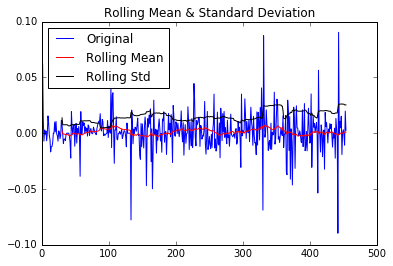

Results of Dickey-Fuller Test:
Test Statistic                 -19.264689
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    452.000000
Critical Value (5%)             -2.867956
Critical Value (1%)             -3.444900
Critical Value (10%)            -2.570187
dtype: float64


In [6]:
rate_log_diff = close_rate[4] - close_rate[4].shift()
rate_log_diff.dropna(inplace=True)
test_stationarity(rate_log_diff)

# ARIMA

![acfPacf](../Desktop/acfPacf.png)

In [8]:
import pyflux as pf
#import pandas as pd
#import pandas_datareader as pdr
import pandas_datareader.data as web
from datetime import datetime
#import matplotlib.pyplot as plt %matplotlib inline

cny_usd = web.DataReader('CNY=X',  'yahoo', datetime(2015,8,12), datetime(2017,5,10))
log_diff = pd.DataFrame(np.diff(np.log(cny_usd['Adj Close'].values)))
log_diff.index = cny_usd.index.values[1:cny_usd.index.values.shape[0]]
log_diff.columns = ['Rate Differencing']

model = pf.ARIMA(data=cny_usd, ar=2, ma=2, family=pf.Normal())
x = model.fit("MLE")
x.summary()


Normal ARIMA(2,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Open                                Method: MLE                                       
Start Date: 2015-08-14 00:00:00                         Log Likelihood: 855.193                           
End Date: 2017-05-10 00:00:00                           AIC: -1698.3859                                   
Number of observations: 453                             BIC: -1673.6906                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0789     0.056      1.4073   0.1593   (-0.031 | 0.1887)        
AR(1)                                

# GARCH

In [23]:
import pyflux as pf
import pandas_datareader.data as web
from datetime import datetime

cny_usd = web.DataReader('CNY=X',  'yahoo', datetime(2015,8,12), datetime(2017,5,4))

log_diff = pd.DataFrame(np.diff(np.log(cny_usd['Adj Close'].values)))
log_diff.index = cny_usd.index.values[1:cny_usd.index.values.shape[0]]
log_diff.columns = ['Exponential Index']

In [24]:
garch_model = pf.GARCH(log_diff,p=1,q=1)
x = garch_model.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Exponential Index                   Method: MLE                                       
Start Date: 2015-08-14 00:00:00                         Log Likelihood: 2095.0363                         
End Date: 2017-05-04 00:00:00                           AIC: -4182.0727                                   
Number of observations: 449                             BIC: -4165.6446                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

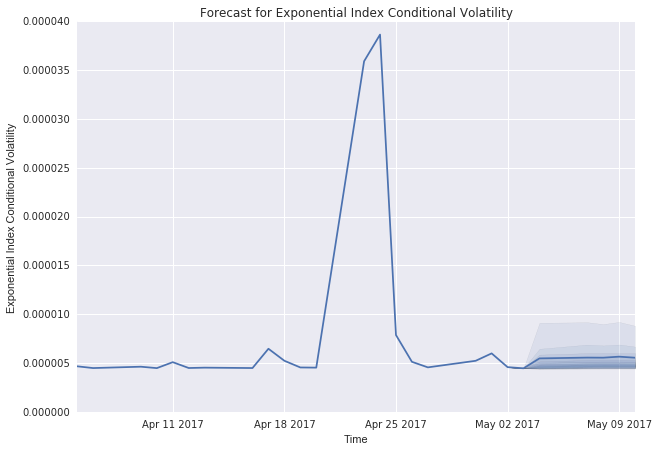

In [25]:
garch_model.plot_predict(h=6)

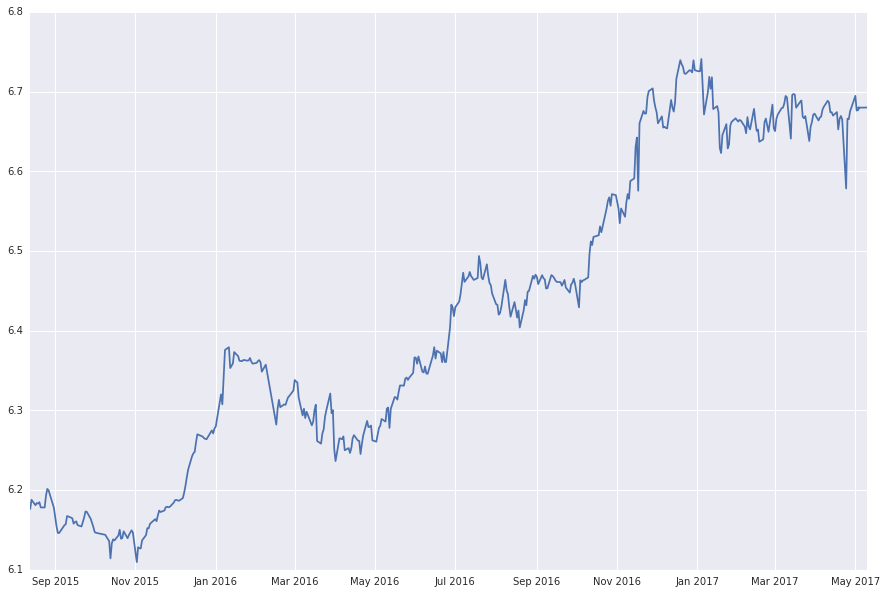

In [45]:
a = garch_model.predict(h=6)
##dynamic_Sample_Prediction is error is future
dynamic_Sample_Prediction = a

## dynamic_Sample_Prediction_log is error data with future error
dynamic_Sample_Prediction_log = log_diff.append(dynamic_Sample_Prediction)
dynamic_Sample_Prediction_log.drop_duplicates(inplace=True)

## dynamic_Sample_Prediction_log_cumsum is cumulate sum of all errors
dynamic_Sample_Prediction_log_cumsum = dynamic_Sample_Prediction_log.cumsum()

## add 1.81094 to all cumsum respectively
dynamic_GARCH_log = dynamic_Sample_Prediction_log_cumsum.add(1.81094)

## back to original data
dynamic_Sample_Prediction_GARCH = np.exp(dynamic_GARCH_log)

plt.figure(figsize=(15,10))
plt.plot(dynamic_Sample_Prediction_GARCH)

# SGD (Stochastic Gradient Descent)

[SGD Research Paper](https://cs.nyu.edu/media/publications/TR2013-953.pdf)

## Currency Correlation

<img src="../Downloads/currency.png" width="400" height="400" />

# Model Comparison

### SGD MSE

![SGDMSE](../Desktop/SGDMSE.png)

### GARCH MSE

In [47]:
from sklearn.metrics import mean_squared_error

true_Data = web.DataReader('CNY=X',  'yahoo', datetime(2017,5,4), datetime(2017,5,10))
train_Data = web.DataReader('CNY=X',  'yahoo', datetime(2015,8,12), datetime(2017,5,4))
prediction_Data = dynamic_Sample_Prediction_GARCH.tail(n=5)
mean_squared_error(true_Data['Close'], prediction_Data)

0.047521002847139934

### ARIMA MSE

![ARIMAMSE](../Desktop/ARIMAMSE.png)

## $ SGD < GARCH < ARIMA $

## Order Selection

### For ARIMA, We calculated ARIMA(1,1,1), ARIMA(2,1,1)...ARIMA(2,1,2)

#### From $Intro$ $to$ $Time$ $Series$ $and$ $Forecasting$, differecing order more than 1 usually will cause overfitting

### For GARCH, We found a paper stated that GARCH(1,1) is the best
[Does anything beat GARCH(1,1)?](http://www.bauer.uh.edu/rsusmel/phd/HansenLunde_Garch.pdf)